# Hierarchical Shap Clustering Reasoning Paths

This notebook creates clusters for each model type in order to determine their reasoning paths:

- **Silhoutte Scores**: Score used to determine cluster accuracy, closer to 1 is better
- **Davies-Bouldin Scores**: Score used to determine cluster accuracy, closer to 0 is better
- **Cophenetic Correlation Coefficient**: Score used to determine cluster accuracy, closer to 1 is better
- **Cluster Sizes**: Way to see how many values are in each cluster, you want each cluster to be as evenly distributed as possible

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet


import os
original_dir = os.getcwd()
if os.path.basename(original_dir) == "Shap":
    os.chdir(os.path.dirname(original_dir))



## Create Clusters From Shap Values

- Print the Scores in order to determine the models accuracy
- Print the Clusters in order to determine how many values are in each cluster

## Create Dendogram to See How Clusters Are Formed and Relate to Each Other

- you can see how each value is similar to other values
- they connect to make a tree like branching until each value is grouped into the designated about of clusters

## Create Heat Map For the Shap Values to Determine Feature Importance

- Once you know the values are grouped you can use a heat map in order to see how each feature determines what the clusters mean
- features marked with BLUE tend to mean moving away from having ASD
- features marked with RED tend to mean moving twards having ASD
- featured marked with white tend to have less influence on ASD



In [39]:

def ShapClustering(shap_values, X_test):

    # Step 1: Average SHAP values across classes (shape: n_samples x n_features)
   
    if hasattr(shap_values, 'values'):
        shap_values_avg = shap_values.values
    elif isinstance(shap_values, list) and isinstance(shap_values[0], np.ndarray):
        shap_values_avg = np.mean(shap_values, axis=0)
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
        shap_values_avg = shap_values
    else:
        shap_values_avg = np.mean(shap_values, axis=2)  # If shap_values is shape (n_samples, n_features, n_classes)

    scaler = StandardScaler()
    shap_scaled = scaler.fit_transform(shap_values_avg)


    pca = PCA(n_components=2)
    shap_pca = pca.fit_transform(shap_scaled)
    #shap_pca = shap_values_avg

    # Step 2: Perform hierarchical clustering
    model = AgglomerativeClustering(4, linkage='average')
    cluster_labels = model.fit_predict(shap_pca)

    # Step 5: Generate the linkage matrix
    Z = linkage(shap_pca, method='average')

    # Step 6: Calculate the Cophenetic Correlation Coefficient
    # Use pdist to get the pairwise distances in condensed format
    distance_matrix = pdist(shap_pca)
    coph_corr, _ = cophenet(Z, distance_matrix)


    # Step 3: Evaluate the clustering
    silhouette = silhouette_score(shap_pca, cluster_labels)
    db_score = davies_bouldin_score(shap_pca, cluster_labels)

    print(f"Silhouette Score for Hierarchical Clustering: {silhouette}")
    print(f"Davies-Bouldin Score for Hierarchical Clustering: {db_score}")
    print(f"Cophenetic Correlation Coefficient: {coph_corr}")

    # Check how many samples are in each cluster
    cluster_counts = Counter(cluster_labels)
    print("Cluster Sizes:", cluster_counts)

    clustered_data = pd.DataFrame(shap_pca, columns=["PCA1", "PCA2"])
    clustered_data['Cluster'] = cluster_labels

    # Display the samples in each cluster
    for cluster in np.unique(cluster_labels):
        print(f"Cluster {cluster}:")
        print(clustered_data[clustered_data['Cluster'] == cluster])

    # Create a DataFrame of SHAP values using feature names from X_test
    shap_df = pd.DataFrame(shap_values_avg, columns=X_test.columns)

    # Add the cluster labels from hierarchical clustering
    shap_df['Cluster'] = cluster_labels

    # Compute mean SHAP values for each feature grouped by cluster
    cluster_mean_shap = shap_df.groupby('Cluster').mean()

    # Transpose for easier plotting (features as rows, clusters as columns)
    cluster_mean_shap_T = cluster_mean_shap.T

    # Plot the dendrogram
    plt.figure(figsize=(20, 20))
    dendrogram(Z)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")

    # Plot the heatmap of SHAP importance per cluster
    plt.figure(figsize=(15, 10))
    sns.heatmap(cluster_mean_shap_T, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Mean SHAP Values per Feature by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")

    plt.tight_layout()
    plt.show()

    X_with_cluster = X_test.copy()  # Or the appropriate feature set you're using
    X_with_cluster['Cluster'] = cluster_labels

    #This gives you a statistical summary per cluster:
    cluster_profiles = X_with_cluster.groupby('Cluster').describe()

    print(cluster_profiles)

    #To view just means per feature per cluster:
    cluster_means = X_with_cluster.groupby('Cluster').mean()
    # Save to CSV if needed
    print(cluster_means)




# Clustering Analysis Report for Robust Regression Model (SHAP Data)

## Clustering Metrics

- **Silhouette Score**: `0.6216`  
  Indicates a reasonably well-defined clustering structure.
  
- **Davies-Bouldin Score**: `0.4636`  
  Lower values suggest good separation and compactness between clusters.
  
- **Cophenetic Correlation Coefficient**: `0.8701`  
  Shows a strong correlation between the distances in the dendrogram and the actual pairwise distances.

## Cluster Distribution

| Cluster | Size |
|---------|------|
| 0       | 59   |
| 1       | 2    |
| 2       | 138  |
| 3       | 1    |

---

## Cluster Descriptions

### Cluster 0
- **Description**: Moderate size cluster with distinct PCA projections.
- **Sample Data Points**:
  
| PCA1     | PCA2     |
|----------|----------|
| 1.658793 | 1.274368 |
| 4.120427 | -0.233815 |
| ...      | ...      |
| 4.555673 | -2.906636 |

### Cluster 1
- **Description**: Small cluster located in lower PCA2 space.
- **Sample Data Points**:

| PCA1     | PCA2     |
|----------|----------|
| 1.833428 | -6.454106 |
| 4.380717 | -6.235089 |

### Cluster 2
- **Description**: Largest cluster representing the main group of data points centered around PCA1 and PCA2 close to 0.
- **Sample Data Points**:

| PCA1     | PCA2     |
|----------|----------|
| -0.632307 | 0.179982 |
| -3.198824 | -0.164148 |
| ...       | ...      |
| -2.208138 | 0.974605 |

### Cluster 3
- **Description**: Outlier cluster with extreme PCA2 values.
- **Sample Data Point**:

| PCA1     | PCA2     |
|----------|----------|
| 8.162616 | -10.614002 |

---

## SHAP Feature Impact by Cluster (Heatmap Overview)

![Mean SHAP Values per Feature by Cluster](attachment:1bc7fb7d-588c-400d-a6fc-dbfd40d15f1a.png)

### Heatmap Summary

- The heatmap visualizes the **mean SHAP values per feature across clusters**.
- **Cluster 0** and **Cluster 3** show positive SHAP contributions for features like `A1_Score`, `A3_Score`, and `A5_Score`.
- **Cluster 2**, the largest cluster, shows predominantly negative SHAP values across almost all features, indicating **lower model impact for these individuals**.
- **Cluster 1** (very small) shows high SHAP values similar to Cluster 3 in some features but also has more variability across demographic features.
- Features like `score_autism` and `gender_result` show **distinct separations**, especially negative in Cluster 2 and positive in the smaller clusters.
- Demographic and country-related features show generally low impact across all clusters, as their SHAP values hover near zero.

### Key Takeaways

- **Clusters 0, 1, and 3** show **elevated SHAP values**, suggesting these groups experience stronger model effects based on the respective features.
- **Cluster 2** is the majority but shows **uniformly lower SHAP contributions**, possibly reflecting users with less distinct or impactful profiles in the model.
- **Gender Result** and **Autism Scores** are highly differentiated among the clusters, indicating possible demographic influence or underlying data imbalance.

---

## Interpretation

- This clustering approach has effectively segmented the user base by **SHAP value behavior**, highlighting **distinct user profiles with differing model sensitivity**.
- The heatmap provides **visual evidence of feature-wise separations between clusters**, supporting the quantitative clustering metrics.
- These insights could be utilized for:
  - Targeted model explanation.
  - Fairness/bias evaluations.
  - User segmentation and personalization.

---

 

Silhouette Score for Hierarchical Clustering: 0.6215993311877936
Davies-Bouldin Score for Hierarchical Clustering: 0.46364962634206086
Cophenetic Correlation Coefficient: 0.8700756788173478
Cluster Sizes: Counter({2: 138, 0: 59, 1: 2, 3: 1})
Cluster 0:
         PCA1      PCA2  Cluster
2    1.658793  1.274368        0
6    4.120427 -0.233815        0
13   2.385871  2.714329        0
15   2.949427  1.491310        0
16   4.751414  1.675373        0
17   4.352776  2.842852        0
20   4.165010  4.508748        0
21   7.034675 -3.004693        0
22   3.925550  3.075808        0
23   5.233509  2.355493        0
26   2.521247  1.674251        0
27   3.931983  0.126207        0
32   8.674258 -2.023806        0
34   4.165574  2.784859        0
35   5.144032  1.995447        0
37   4.245201  1.245161        0
41   4.001286 -3.535882        0
47   7.595730 -1.071395        0
52   8.219581  2.625917        0
53   4.660934  3.420386        0
64   2.459962  0.911539        0
66   5.413855  2.3336

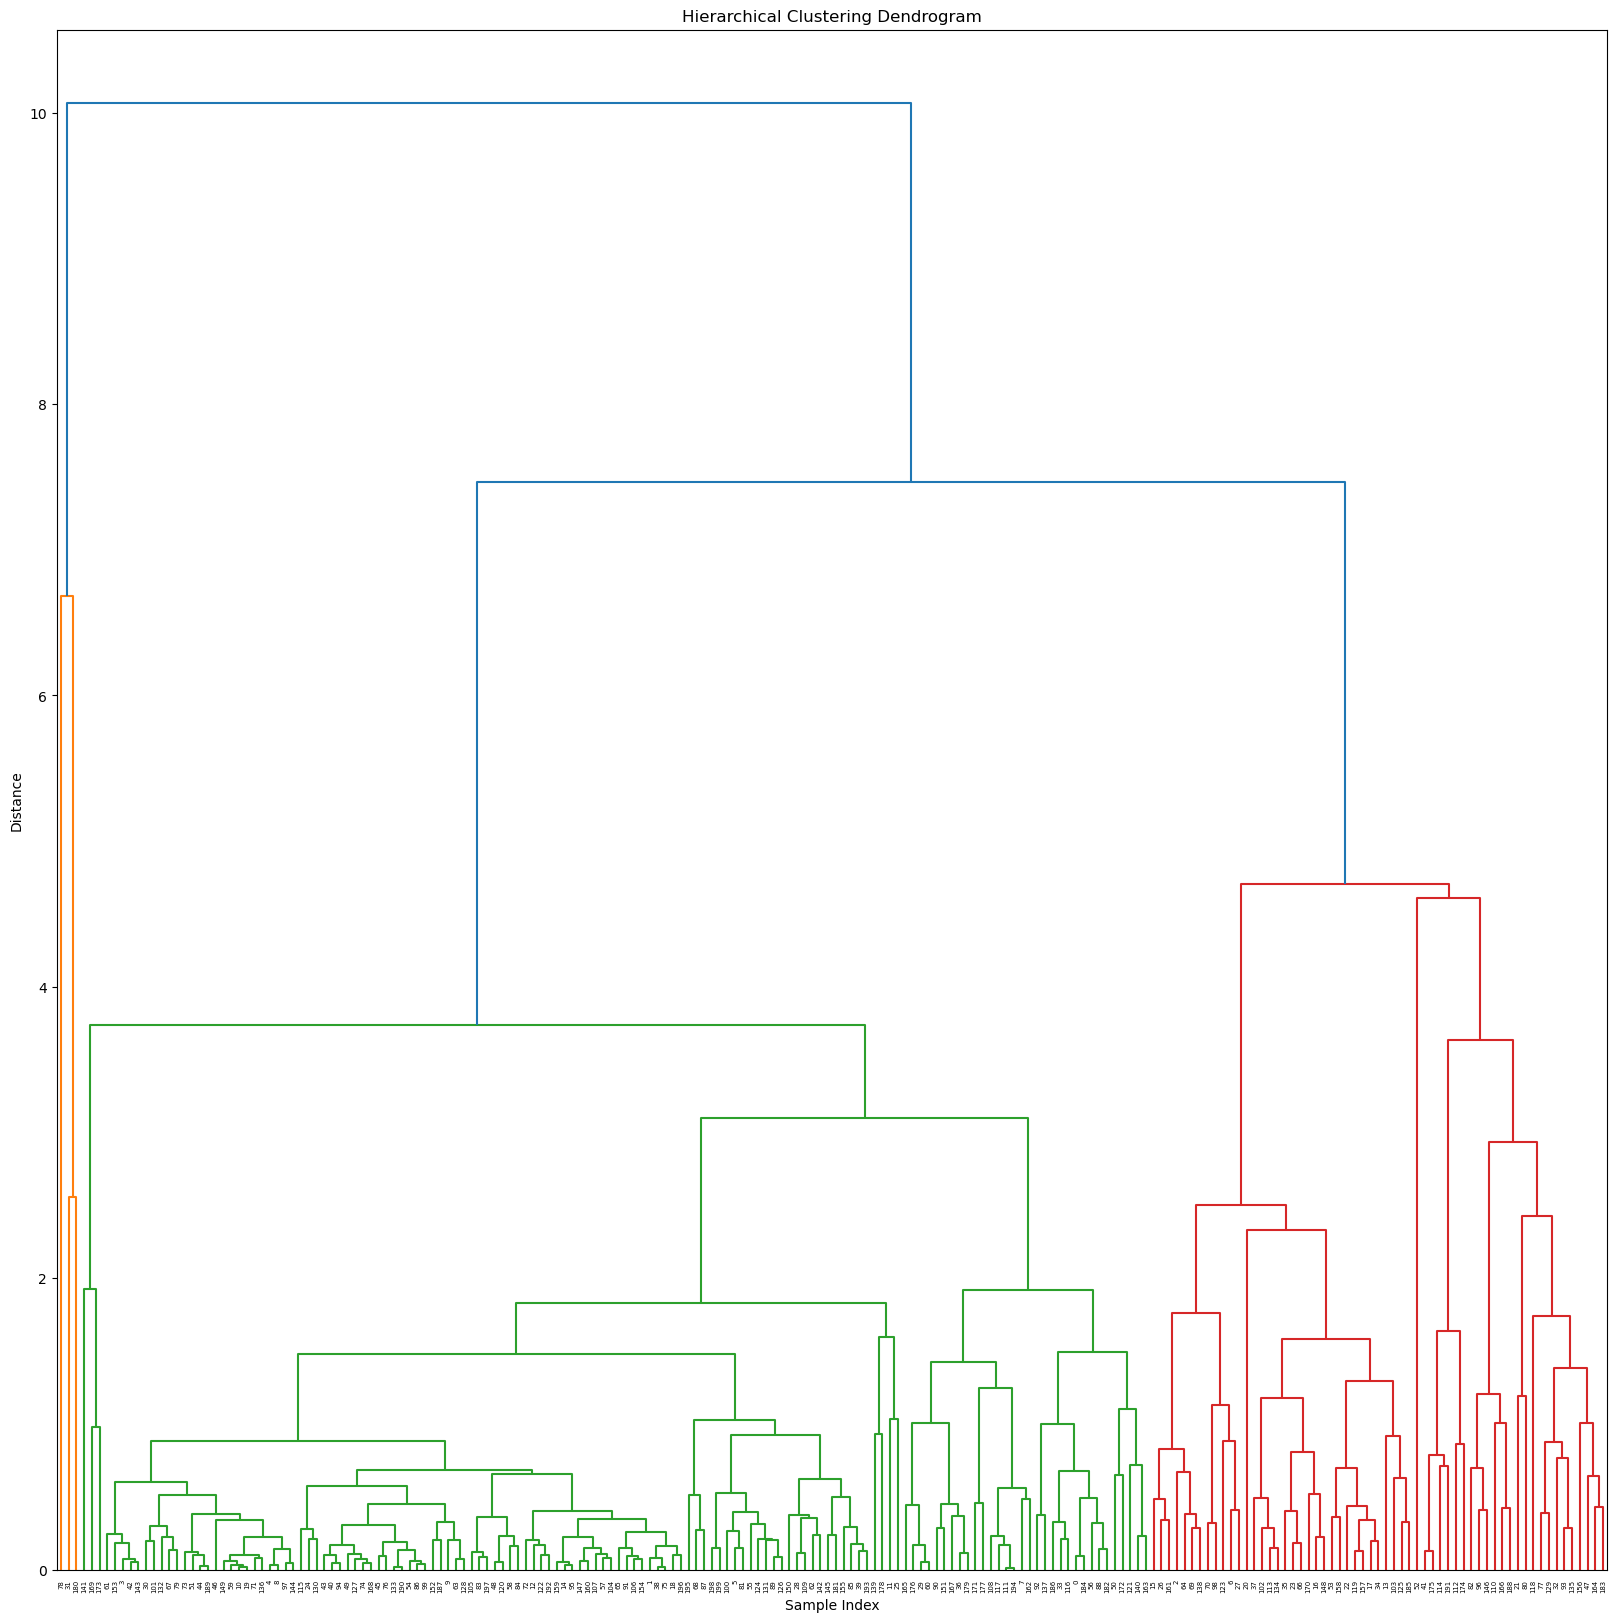

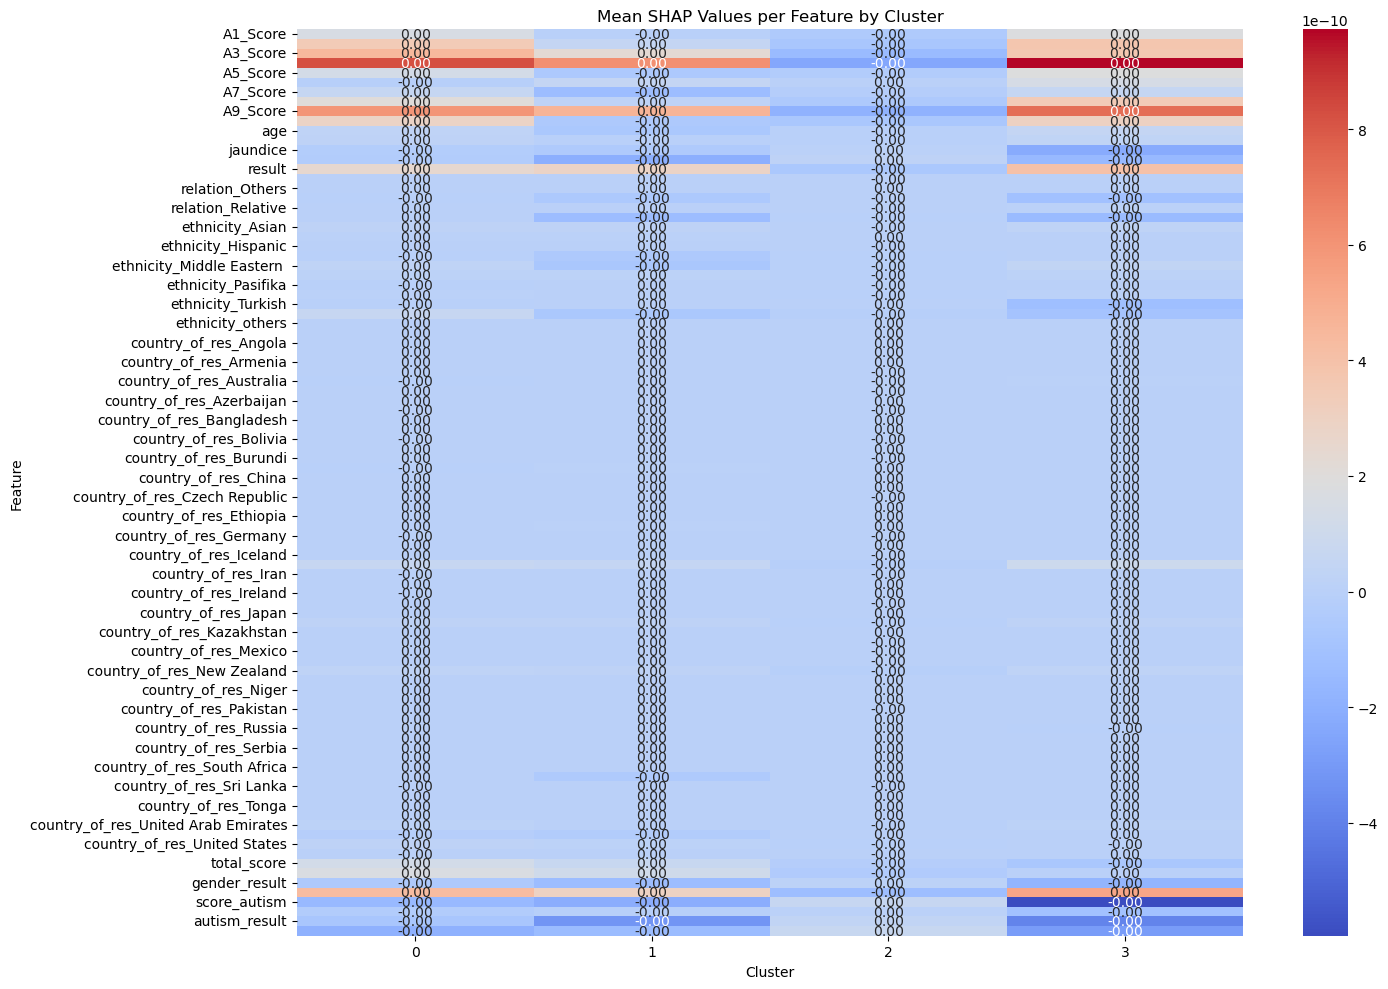

        A1_Score                                                              \
           count      mean       std       min       25%       50%       75%   
Cluster                                                                        
0           59.0  0.688296  0.568216 -1.163160  0.859727  0.859727  0.859727   
1            2.0 -0.151717  1.430397 -1.163160 -0.657438 -0.151717  0.354005   
2          138.0 -0.298303  1.004411 -1.163160 -1.163160 -1.163160  0.859727   
3            1.0  0.859727       NaN  0.859727  0.859727  0.859727  0.859727   

                  A2_Score            ... autism_result            \
              max    count      mean  ...           75%       max   
Cluster                               ...                           
0        0.859727     59.0  0.827223  ...      2.227569  3.127246   
1        0.859727      2.0 -0.110672  ...      2.748780  2.865363   
2        0.859727    138.0 -0.358553  ...     -0.389939  2.698311   
3        0.859727      1.

In [40]:
%run Shap/ReportShapExplainer.ipynb
%run SupervisedModels/SupervisedRandomForest.ipynb

shap_values = explain_model_with_shap(rf_model, X_test, "Random Forest")

ShapClustering(shap_values, X_test)

Silhouette Score for Hierarchical Clustering: 0.5848090500393903
Davies-Bouldin Score for Hierarchical Clustering: 0.7266664107738896
Cophenetic Correlation Coefficient: 0.820240759890959
Cluster Sizes: Counter({0: 113, 1: 62, 2: 23, 3: 2})
Cluster 0:
         PCA1      PCA2  Cluster
1   -3.347048 -0.056660        0
3   -3.158423  0.072194        0
4   -2.861841  0.474057        0
5   -2.188312 -0.058048        0
7   -1.097825 -0.474531        0
..        ...       ...      ...
195 -0.905481 -1.607041        0
196 -3.161898 -0.027190        0
197 -2.278422  0.702543        0
198 -2.195029 -0.230570        0
199 -2.537104 -0.107443        0

[113 rows x 3 columns]
Cluster 1:
         PCA1      PCA2  Cluster
0    0.613306 -1.326814        1
2    2.297242 -0.968352        1
6    3.383625 -1.345922        1
13   2.000944 -2.013183        1
15   1.925615 -0.899989        1
..        ...       ...      ...
182 -0.122044  0.206436        1
184 -0.103175 -0.553253        1
185  2.244239 -1.909

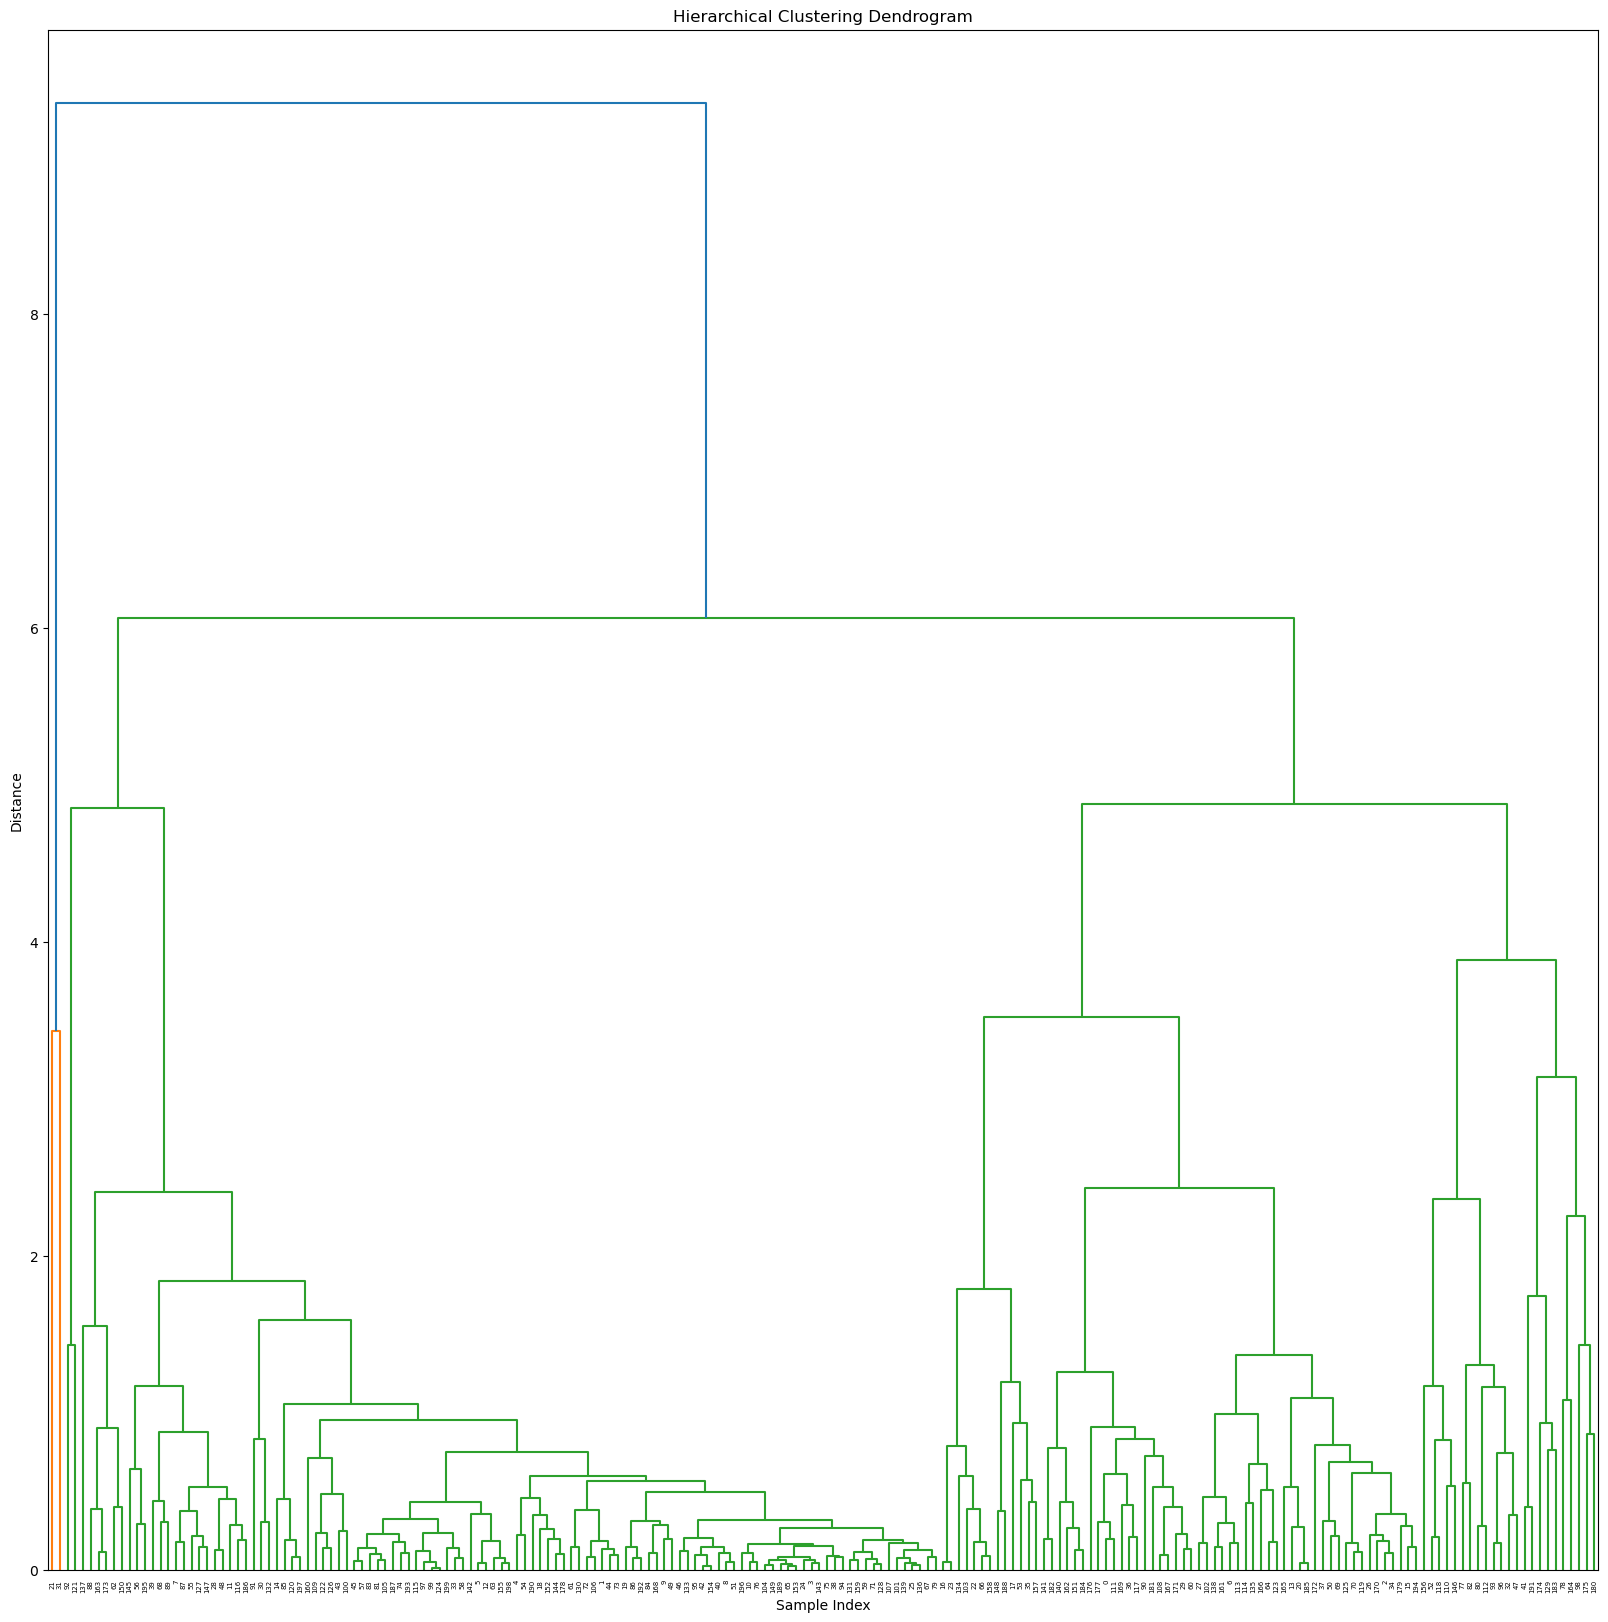

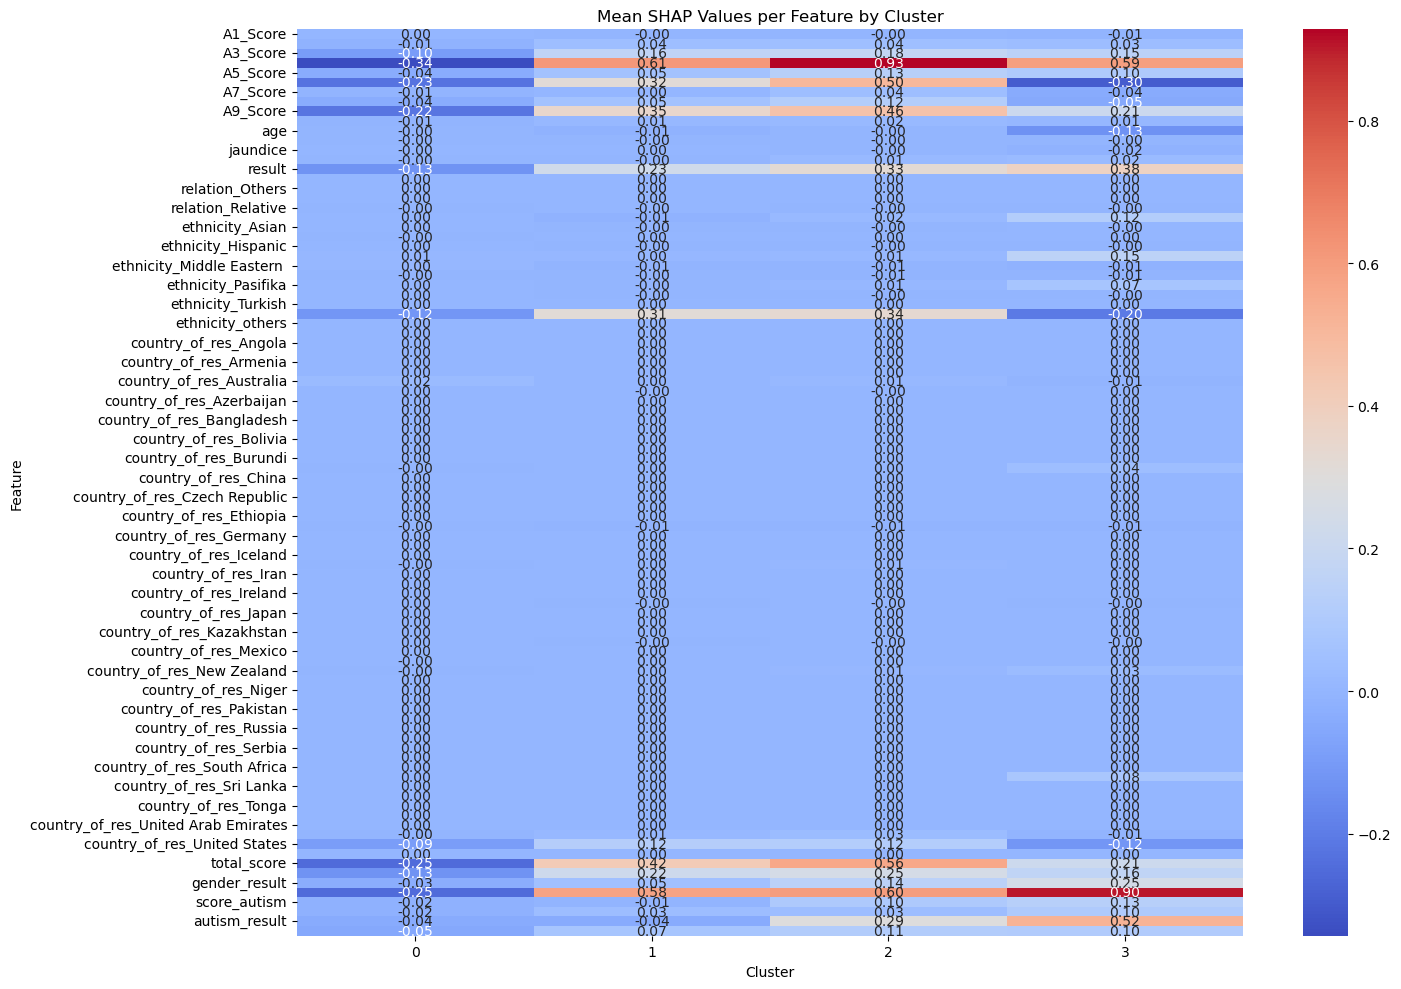

        A1_Score                                                             \
           count      mean       std      min       25%       50%       75%   
Cluster                                                                       
0          113.0 -0.429192  0.976971 -1.16316 -1.163160 -1.163160  0.859727   
1           62.0  0.533455  0.750089 -1.16316  0.859727  0.859727  0.859727   
2           23.0  0.683824  0.582802 -1.16316  0.859727  0.859727  0.859727   
3            2.0 -0.151717  1.430397 -1.16316 -0.657438 -0.151717  0.354005   

                  A2_Score            ... autism_result            \
              max    count      mean  ...           75%       max   
Cluster                               ...                           
0        0.859727    113.0 -0.529140  ...     -0.389939  2.698311   
1        0.859727     62.0  0.668249  ...     -0.389939  0.109314   
2        0.859727     23.0  0.807946  ...      2.867957  3.127246   
3        0.859727      2.0 -0.11

In [41]:
%run Shap/ReportShapExplainer.ipynb
%run SupervisedModels/SupervisedXGBoost.ipynb

shap_values = explain_model_with_shap(xgb_model, X_test, "XGBoost")

ShapClustering(shap_values, X_test)

[[ 0.1165078   0.18115675 -0.28705824 ...  0.1767661  -0.07661889
   0.19753896]
 [ 0.38614007 -0.19684379 -0.29842843 ... -0.09676428 -0.12247216
  -0.07838784]
 [ 0.02259854  0.23792051  0.33408074 ...  0.42524789 -0.05702109
   0.19195661]
 ...
 [ 0.24342556 -0.20697243 -0.3380533  ... -0.05741877 -0.10508282
   0.12979324]
 [-0.19900578  0.34832336 -0.3263262  ... -0.07480938 -0.08325833
  -0.05012427]
 [ 0.26205109 -0.21157919 -0.1208357  ... -0.06199859 -0.09592244
  -0.01524946]]
Silhouette Score for Hierarchical Clustering: 0.5183840315714813
Davies-Bouldin Score for Hierarchical Clustering: 0.6191008618022147
Cophenetic Correlation Coefficient: 0.7932573034079303
Cluster Sizes: Counter({2: 133, 1: 56, 0: 10, 3: 1})
Cluster 0:
         PCA1      PCA2  Cluster
31   1.849629  5.852256        0
77   6.517120  4.162958        0
78   5.144845  5.588912        0
80   5.196446  4.224826        0
82   7.071210  5.583822        0
92   1.348027  3.431076        0
96   6.483990  3.233260 

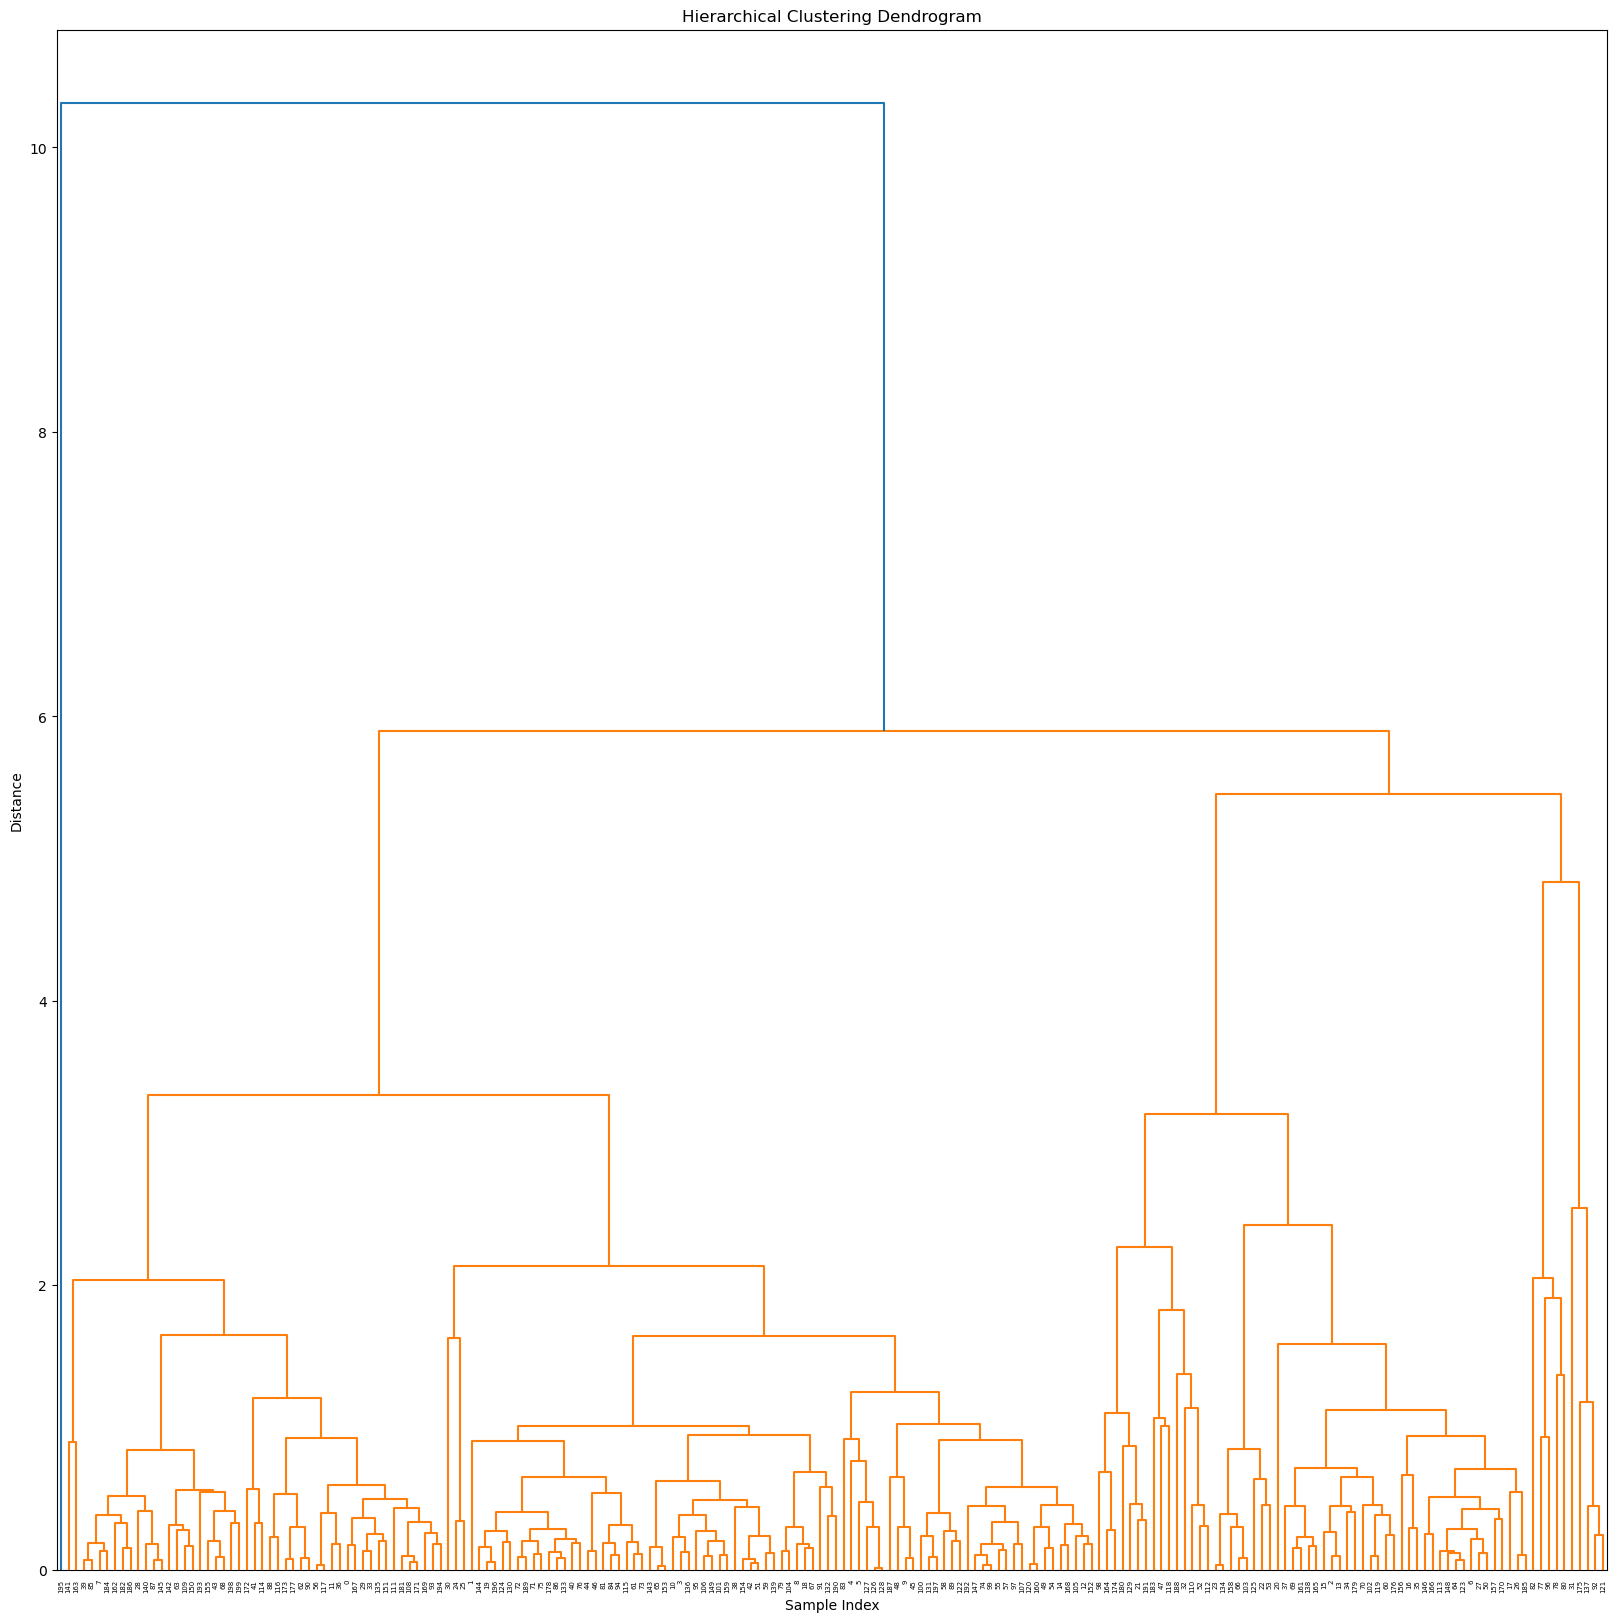

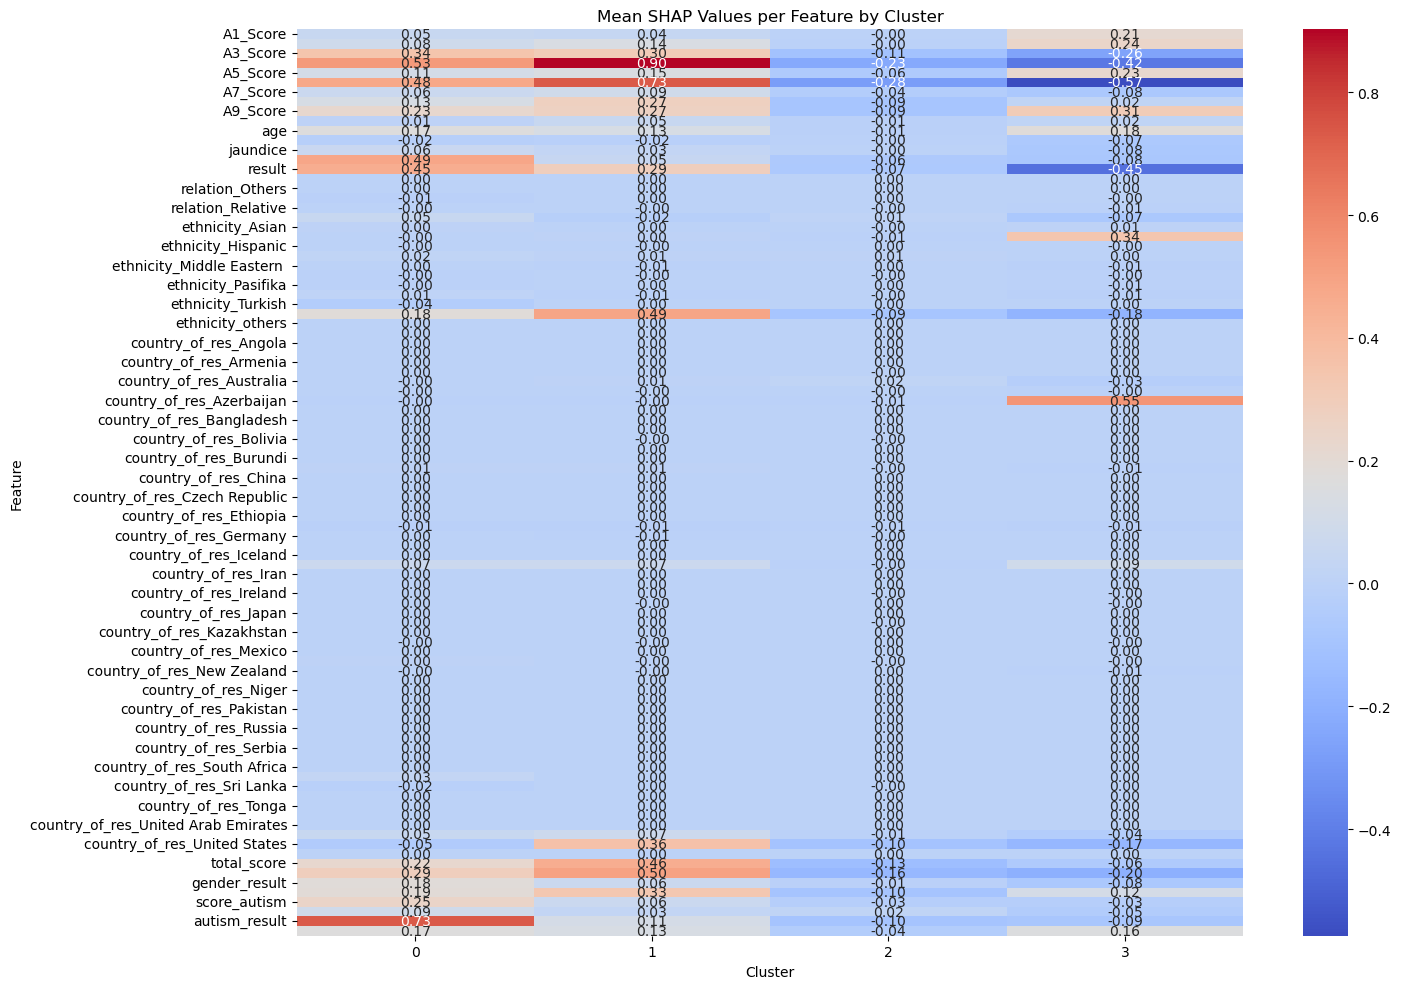

        A1_Score                                                              \
           count      mean       std       min       25%       50%       75%   
Cluster                                                                        
0           10.0  0.252861  0.977147 -1.163160 -0.657438  0.859727  0.859727   
1           56.0  0.606866  0.675061 -1.163160  0.859727  0.859727  0.859727   
2          133.0 -0.280999  1.006940 -1.163160 -1.163160 -1.163160  0.859727   
3            1.0  0.859727       NaN  0.859727  0.859727  0.859727  0.859727   

                  A2_Score            ... autism_result            \
              max    count      mean  ...           75%       max   
Cluster                               ...                           
0        0.859727     10.0  0.291771  ...      2.756500  3.127246   
1        0.859727     56.0  0.787637  ...      1.566393  2.957530   
2        0.859727    133.0 -0.360307  ...     -0.389939  3.093616   
3        0.859727      1.

In [42]:
%run Shap/ReportShapExplainer.ipynb
%run SupervisedModels/SupervisedCatBoost.ipynb

shap_values = explain_model_with_shap(cb_model, X_test, "CatBoost")

print(shap_values)

ShapClustering(shap_values, X_test)

[[-0.33430143  0.3579869  -0.12562842 ... -0.06958287 -0.47548436
   0.73978509]
 [-0.33430143 -0.29289837 -0.12562842 ...  0.03691179 -0.47548436
  -0.2026163 ]
 [-0.33430143  0.3579869   0.16653069 ... -0.17911509 -0.47548436
   1.21098579]
 ...
 [-0.33430143 -0.29289837 -0.12562842 ...  0.03691179 -0.47548436
   0.2685844 ]
 [ 0.39244081  0.3579869  -0.12562842 ...  0.03691179 -0.47548436
  -0.67381699]
 [-0.33430143 -0.29289837 -0.12562842 ...  0.03691179 -0.47548436
  -0.67381699]]
Silhouette Score for Hierarchical Clustering: 0.5274529468468933
Davies-Bouldin Score for Hierarchical Clustering: 0.4956812497327008
Cophenetic Correlation Coefficient: 0.7912525892072725
Cluster Sizes: Counter({0: 104, 1: 92, 3: 3, 2: 1})
Cluster 0:
         PCA1      PCA2  Cluster
0    1.114002  0.064606        0
2    2.739244  1.475279        0
6    3.162391  0.238548        0
7   -0.117883  1.966583        0
13   2.222265  1.593235        0
..        ...       ...      ...
186  0.186737  0.165318  

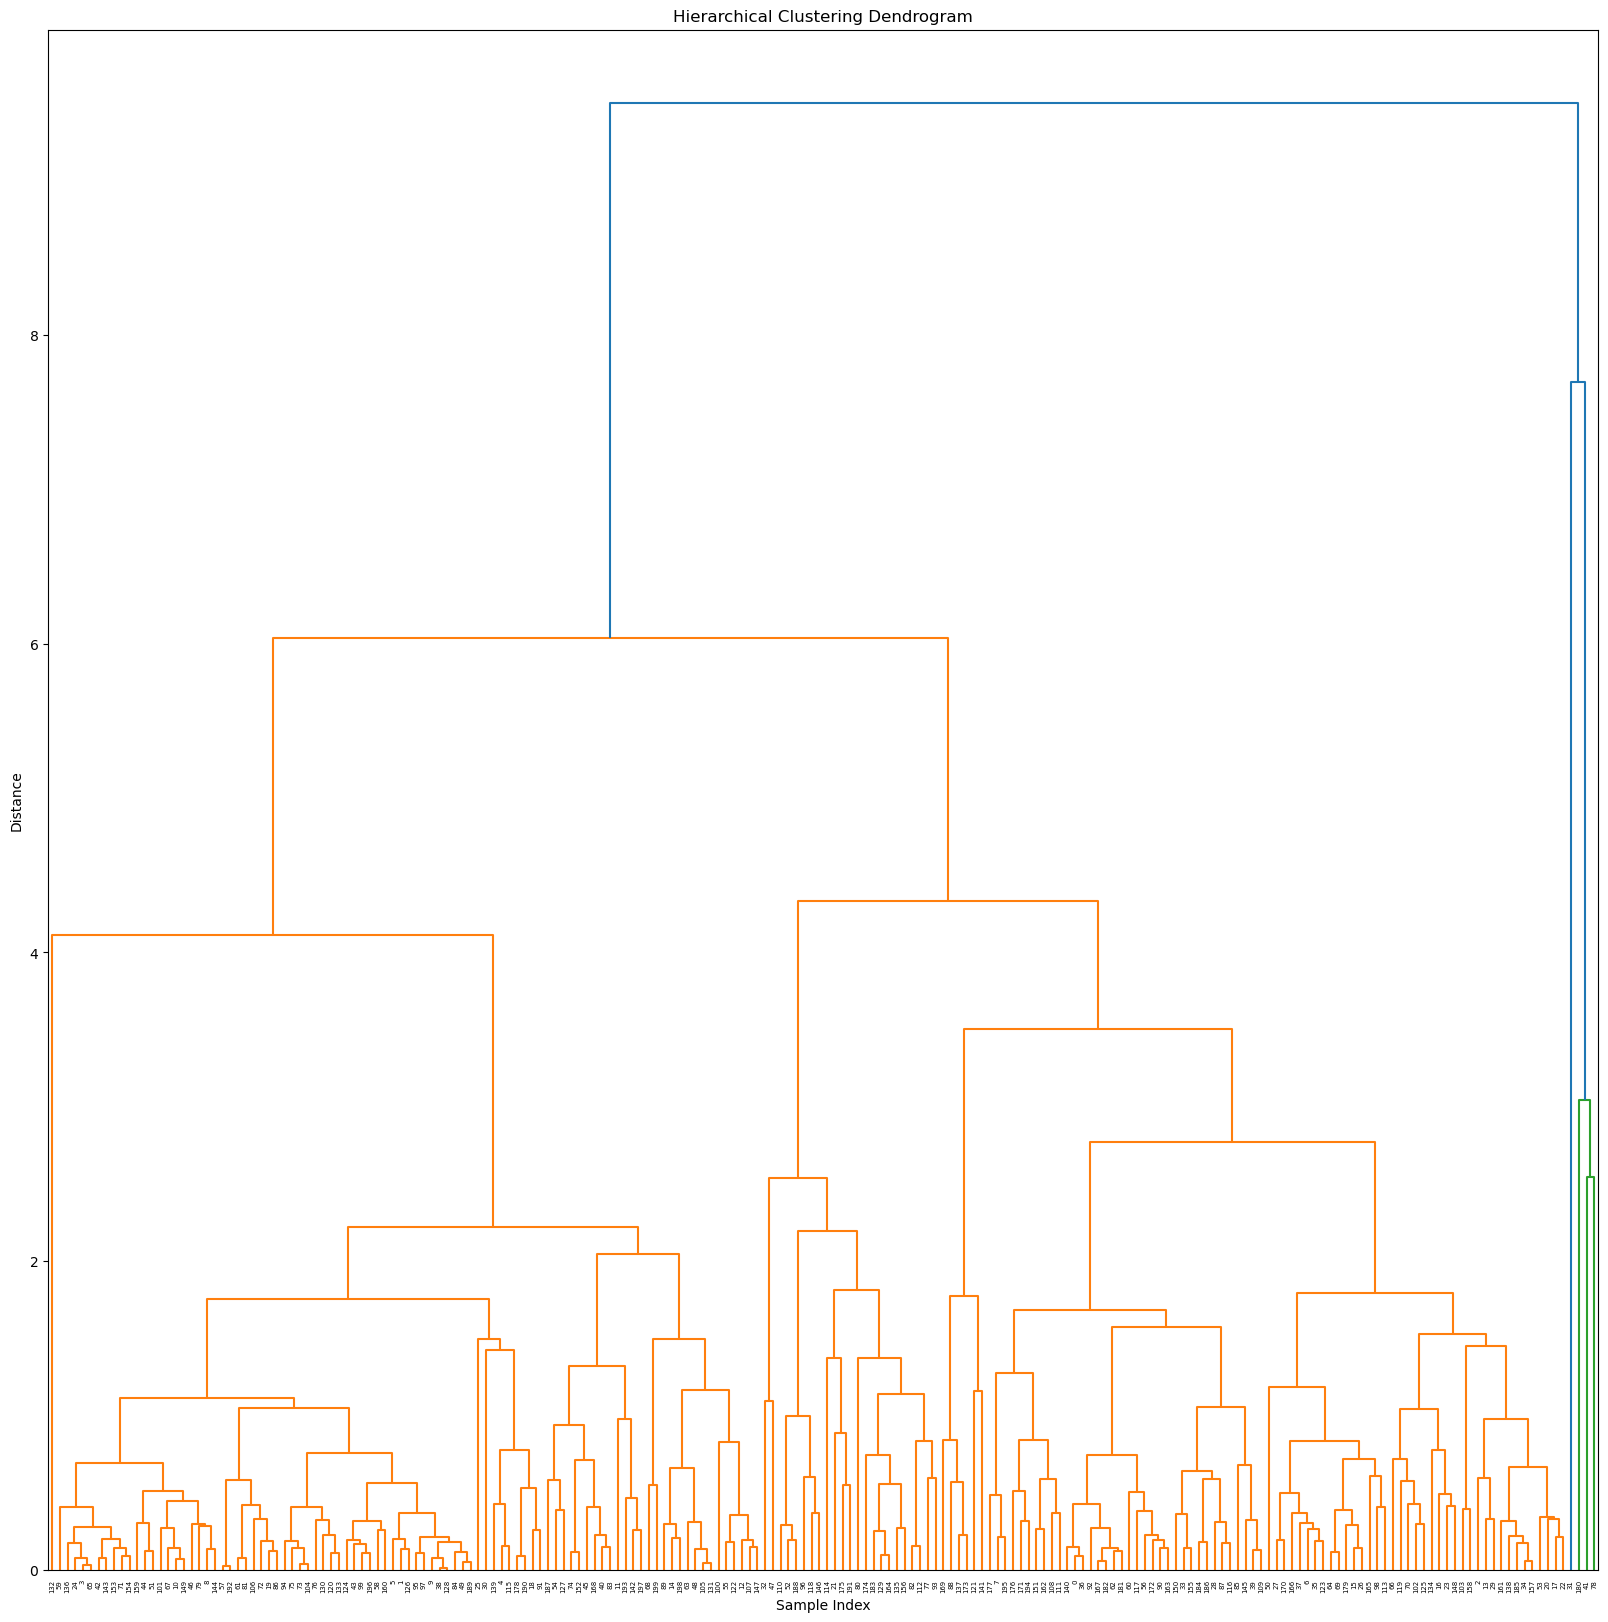

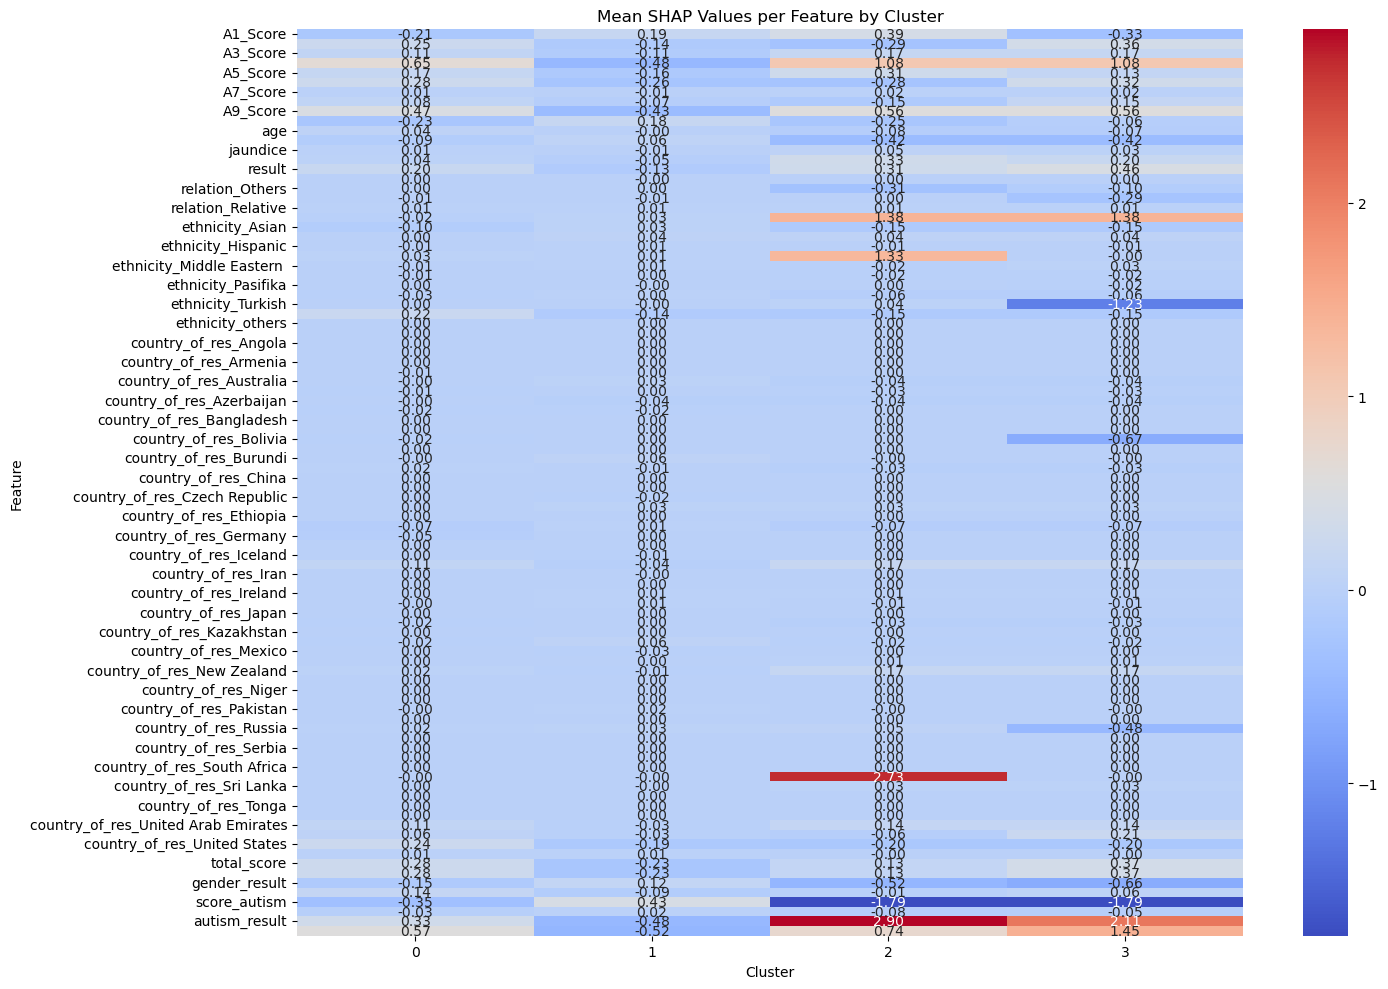

        A1_Score                                                              \
           count      mean       std       min       25%       50%       75%   
Cluster                                                                        
0          104.0  0.509612  0.768992 -1.163160  0.859727  0.859727  0.859727   
1           92.0 -0.591475  0.915832 -1.163160 -1.163160 -1.163160  0.859727   
2            1.0 -1.163160       NaN -1.163160 -1.163160 -1.163160 -1.163160   
3            3.0  0.859727  0.000000  0.859727  0.859727  0.859727  0.859727   

                  A2_Score            ... autism_result            \
              max    count      mean  ...           75%       max   
Cluster                               ...                           
0        0.859727    104.0  0.566515  ...     -0.389939  3.127246   
1        0.859727     92.0 -0.657468  ...     -0.389939 -0.389939   
2       -1.163160      1.0 -1.116777  ...      2.399030  2.399030   
3        0.859727      3.

In [43]:
%run Shap/ReportShapExplainer.ipynb
%run SupervisedModels/SupervisedLogisticRegression.ipynb

shap_values = explain_model_with_shap(lr_model, X_test, "Logistic Regression")

print(shap_values)

ShapClustering(shap_values, X_test)

Hierarchical Clustering Dendrogram
each index item is a person and they connect based on some relation to eachother

Mean SHAP Values per Feature by Cluster
this shows what features have an impact on which clusters
blue leans awasy from having asd
red leans twards having asd 
wight means nothing/no lean